# Задача 2. Линейная регрессия, метод градиентного спуска

* **Дедлайн**: 31.10.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [ ] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [ ] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [ ] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [ ] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [ ] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [ ] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [ ] При обучении моделей использовать **масштабирование данных**.
- [ ] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [ ] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [ ] Повторить тоже самое, но используя **кросс-валидацию**.
- [ ] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [ ] * (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [ ] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [ ] * (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [ ] * (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.


## 1. Импорт библиотек


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. sgd


In [3]:
class LossFunction(ABC):
    def __init__(self, weights):
        self.weights = weights 

    @abstractmethod
    def loss(self, x_input, y_true):
        raise NotImplementedError

    @abstractmethod
    def gradient(self, x_input, y_true):
        raise NotImplementedError

class ABCGradientDescent(ABC):
    def __init__(self, weights: np.ndarray, l_rate: float, loss_function: LossFunction):
        self.weights = weights
        self.l_rate = l_rate
        self.loss_function = loss_function
    
    @abstractmethod
    def step(self, x_input: np.ndarray, y_true: np.ndarray):
        pass

In [4]:
class MSELossWithL2(LossFunction):
    def __init__(self, weights, l2_reg):
        super().__init__(weights)
        self.l2_reg = l2_reg

    def _add_intercept_column(self, x_input: np.ndarray) -> np.ndarray:
        return np.column_stack([x_input, np.ones(x_input.shape[0])])

    def loss(self, x_input: np.ndarray, y_true: np.ndarray) -> float:
        X = self._add_intercept_column(x_input)
        y_pred = X @ self.weights
        n = X.shape[0]
        
        if n == 0: return 0.0
        mse = np.mean((y_pred - y_true) ** 2)
        reg = self.l2_reg * np.sum(self.weights[:-1] ** 2)
        return mse + reg

    def gradient(self, x_input: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        X = self._add_intercept_column(x_input)
        n = X.shape[0]
        
        if n == 0:
            return np.zeros_like(self.weights)
        
        residuals = X @ self.weights - y_true
        grad_mse = (2.0 / n) * X.T @ residuals
        reg_grad = np.zeros_like(self.weights)
        reg_grad[:-1] = 2 * self.l2_reg * self.weights[:-1]
        
        return grad_mse + reg_grad

class BatchGradientDescentOptimizer(ABCGradientDescent):
    def __init__(self, weights: np.ndarray, l_rate: float, loss_function: LossFunction):
        super().__init__(weights, l_rate, loss_function)

    def step(self, x_input: np.ndarray, y_true: np.ndarray):
        grad = self.loss_function.gradient(x_input, y_true)
        self.weights -= self.l_rate * grad
        return self.weights

class SGDGradientDescentOptimizer(ABCGradientDescent):
    def __init__(self, weights: np.ndarray, l_rate: float, loss_function: LossFunction):
        super().__init__(weights, l_rate, loss_function)

    def step(self, x_input: np.ndarray, y_true: np.ndarray):
        x_sample = x_input.reshape(1, -1)
        y_sample = y_true.reshape(1, -1)
        
        grad = self.loss_function.gradient(x_sample, y_sample)
        self.weights -= self.l_rate * grad
        return self.weights

class MiniBatchGradientDescentOptimizer(ABCGradientDescent):
    def __init__(self, weights: np.ndarray, l_rate: float, loss_function: LossFunction):
        super().__init__(weights, l_rate, loss_function)

    def step(self, x_input: np.ndarray, y_true: np.ndarray):
        grad = self.loss_function.gradient(x_input, y_true)
        self.weights -= self.l_rate * grad
        return self.weights

In [5]:
def gradient_descent(X: np.ndarray, y: np.ndarray, 
                     l_rate: float = 0.01, l2_reg: float = 0.01, 
                     epochs: int = 1000) -> np.ndarray:
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    num_features = X.shape[1]
    weights = np.random.randn(num_features + 1, 1) * 0.01 
    
    loss = MSELossWithL2(weights, l2_reg)
    optimizer = BatchGradientDescentOptimizer(weights, l_rate, loss)
    for _ in range(epochs):
        optimizer.step(X, y)
    return weights

def gradient_descent_sgd(X: np.ndarray, y: np.ndarray, 
                         l_rate: float = 0.001, l2_reg: float = 0.01, 
                         epochs: int = 100) -> np.ndarray:
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    num_samples, num_features = X.shape
    weights = np.random.randn(num_features + 1, 1) * 0.01
    
    loss = MSELossWithL2(weights, l2_reg)
    optimizer = SGDGradientDescentOptimizer(weights, l_rate, loss)
    
    for _ in range(epochs):
        indices = np.random.permutation(num_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(num_samples):
            optimizer.step(X_shuffled[i], y_shuffled[i])
            
    return weights

def gradient_descent_minibatch(X: np.ndarray, y: np.ndarray, 
                               l_rate: float = 0.001, l2_reg: float = 0.01, 
                               epochs: int = 100, batch_size: int = 32) -> np.ndarray:
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    num_samples, num_features = X.shape
    weights = np.random.randn(num_features + 1, 1) * 0.01
    
    loss = MSELossWithL2(weights, l2_reg)
    optimizer = MiniBatchGradientDescentOptimizer(weights, l_rate, loss)
    
    for _ in range(epochs):
        indices = np.random.permutation(num_samples)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for i in range(0, num_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            optimizer.step(X_batch, y_batch)
            
    return weights

In [6]:
def predict(X: np.ndarray, weights: np.ndarray) -> np.ndarray:
    X_b = np.column_stack([X, np.ones(X.shape[0])])
    return X_b @ weights

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
        
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    return {'MSE': mse, 'RMSE': rmse, 'R2': r2}

## 3. еда EDA

In [7]:
data_url = 'https://raw.githubusercontent.com/rustam-azimov/ml-course-itmo/main/data/car_price/car_price.csv'

try:
    df = pd.read_csv(data_url)
    display(df.head())
except Exception as e:
    print(f"пупупу {e}")

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Cleaning

In [8]:
print("Информация о DataFrame:")
df.info()

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        20

In [9]:
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [10]:
print("\nОписательная статистика (числовые признаки):")
display(df.describe())


Описательная статистика (числовые признаки):


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [11]:
print("\nОписательная статистика (категориальные признаки):")
display(df.describe(include=['object']))


Описательная статистика (категориальные признаки):


,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,peugeot 504,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


* Пропущенных нет, с кайфом
* Признак `car_ID` дроп.
* `CarName` много уникальных, мб просто марку спарсить попробовать

In [12]:
df['brand'] = df['CarName'].apply(lambda x: x.split(' ')[0].lower())


# print(df['brand'].unique())
df['brand'] = df['brand'].replace({
    'maxda': 'mazda',
    'porcshce': 'porsche',

    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
})

df = df.drop(['car_ID', 'CarName'], axis=1)
display(df.head())

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,brand
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


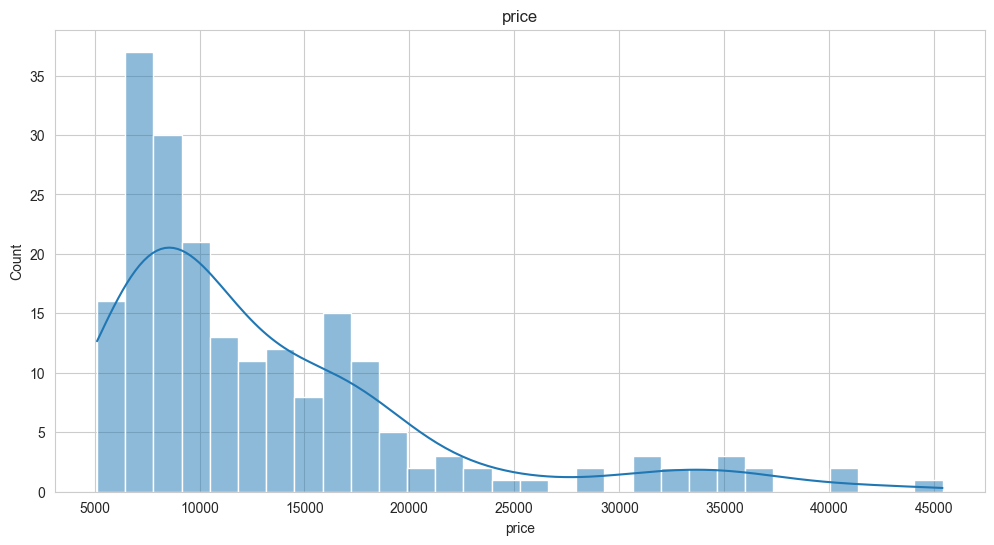

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, bins=30)
plt.title('price')
plt.show()

ну скошено - минус вайб
можно логарифмировать и log_price предиктить, потом потенцировать

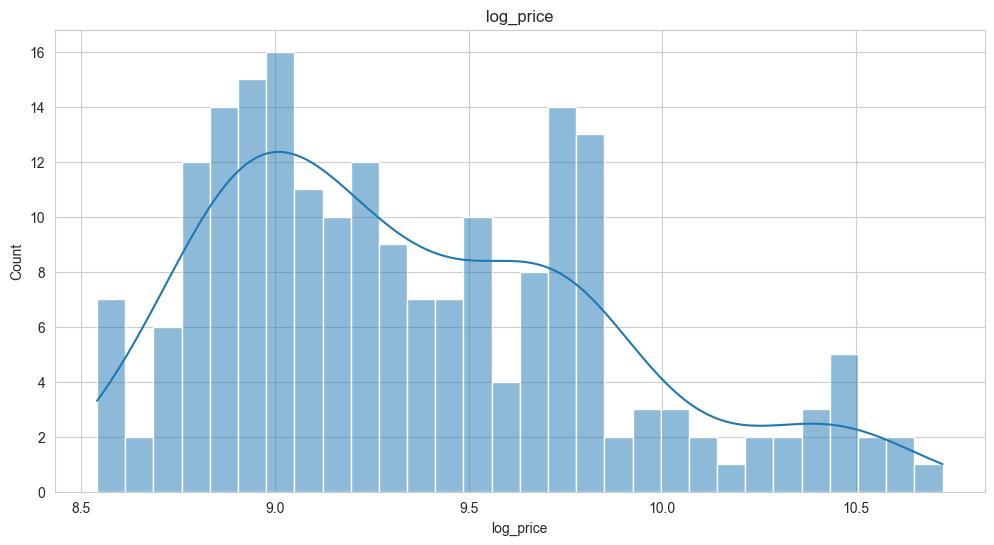

In [14]:
df['log_price'] = np.log1p(df['price']) 
plt.figure(figsize=(12, 6))
sns.histplot(df['log_price'], kde=True, bins=30)
plt.title('log_price')
plt.show()

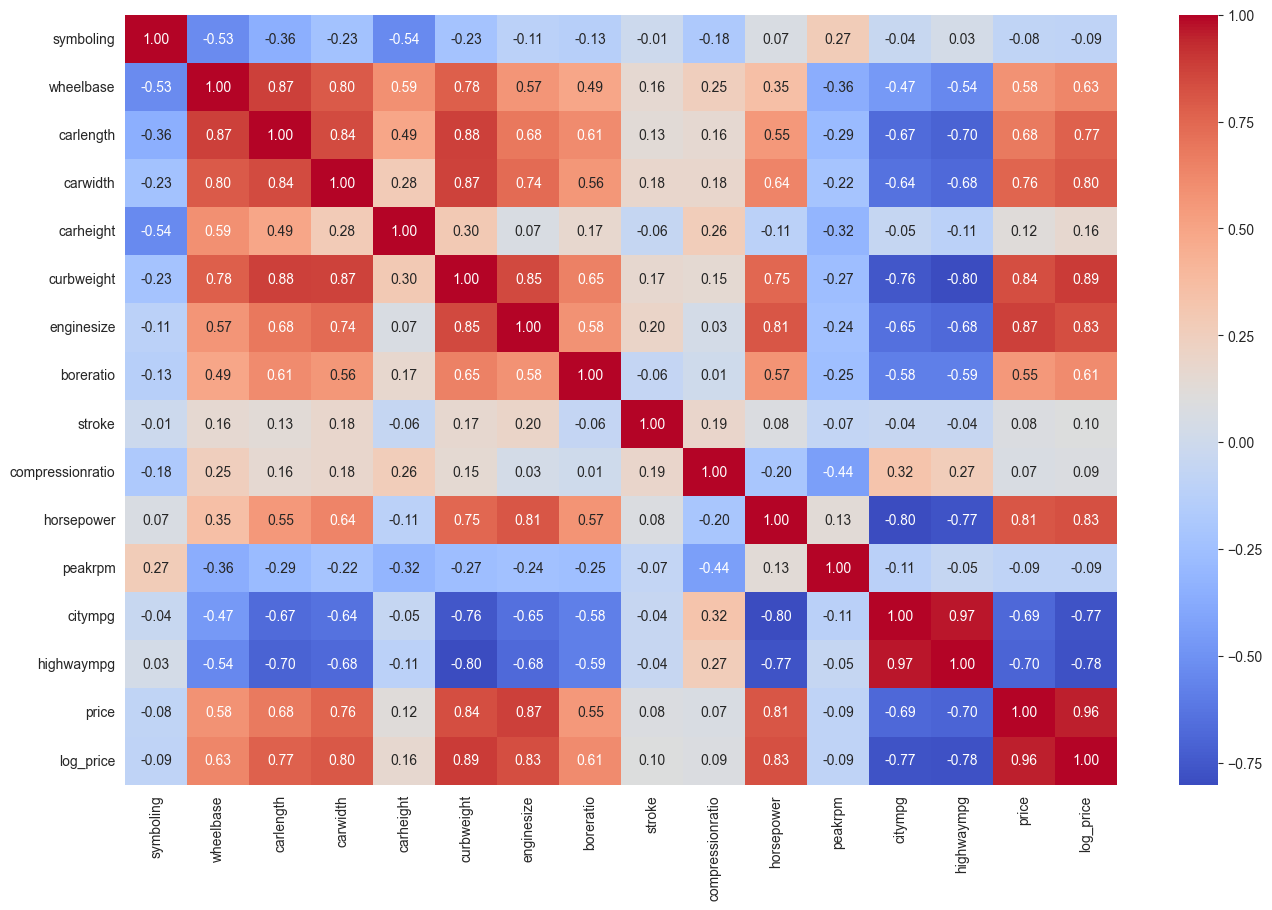

In [15]:
plt.figure(figsize=(16, 10))
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

* `log_price` коррелирует с `enginesize`, `curbweight`, `horsepower`, `carwidth`.
* `log_price` отрицательно коррелирует `citympg` и `highwaympg`, но тут в целом логично
* `curbweight`, `enginesize` и `horsepower` сильно коррелируют друг с другом. 

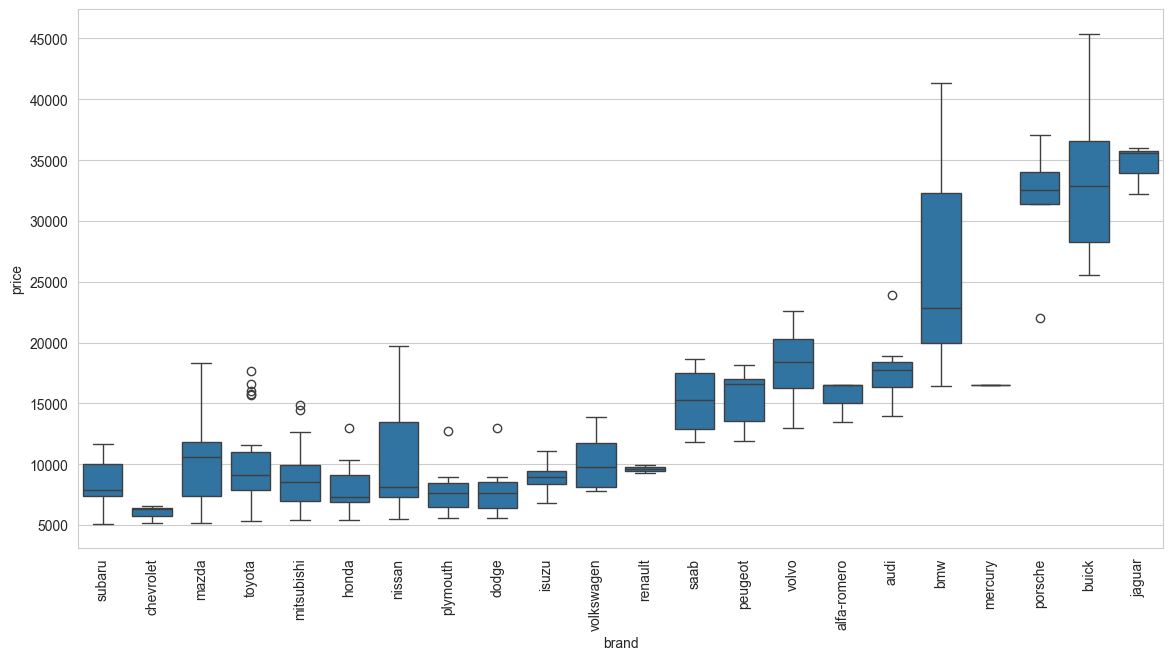

In [16]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=df.sort_values('price'), x='brand', y='price')
plt.xticks(rotation=90)
plt.show()

## 4. Подготовка данных (Feature Engineering & Preprocessing)

In [17]:
X = df.drop(['price', 'log_price'], axis=1)
y = df['log_price'] 
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

Числовые признаки (14): ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']
Категориальные признаки (10): ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train len: {X_train.shape}")
print(f"test len: {X_test.shape}")

train len: (164, 24)
test len: (41, 24)


In [19]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

feature_names = numeric_features + preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()


In [20]:
y_train_np = y_train.values.reshape(-1, 1)
y_test_np = y_test.values.reshape(-1, 1)

X_scaled = preprocessor.fit_transform(X)
y_np = y.values.reshape(-1, 1)

## 5. Обучение моделей (простой Train/Test Split)

Сравним нашу реализацию `gradient_descent` (Batch GD) и `Ridge` из `sklearn`.

In [21]:
l_rate = 0.01
l2_reg = 0.1
epochs = 2000

print("Batch GD")
w_my_gd = gradient_descent(X_train_scaled, y_train_np, 
                           l_rate=l_rate, l2_reg=l2_reg, epochs=epochs)

y_pred_train_log_my_gd = predict(X_train_scaled, w_my_gd)
y_pred_test_log_my_gd = predict(X_test_scaled, w_my_gd)

y_train_orig = np.expm1(y_train_np)
y_test_orig = np.expm1(y_test_np)
y_pred_train_my_gd = np.expm1(y_pred_train_log_my_gd)
y_pred_test_my_gd = np.expm1(y_pred_test_log_my_gd)

metrics_my_gd_train = evaluate_model(y_train_orig, y_pred_train_my_gd)
metrics_my_gd_test = evaluate_model(y_test_orig, y_pred_test_my_gd)

print("Done Batch GD")

Batch GD
Done Batch GD


In [22]:
# ridge
model_ridge = Ridge(alpha=l2_reg)
model_ridge.fit(X_train_scaled, y_train_np)

y_pred_train_log_ridge = model_ridge.predict(X_train_scaled)
y_pred_test_log_ridge = model_ridge.predict(X_test_scaled)

y_pred_train_ridge = np.expm1(y_pred_train_log_ridge)
y_pred_test_ridge = np.expm1(y_pred_test_log_ridge)

metrics_ridge_train = evaluate_model(y_train_orig, y_pred_train_ridge)
metrics_ridge_test = evaluate_model(y_test_orig, y_pred_test_ridge)


In [31]:
# --- Сравнение --- \n",
results = {
    'My Batch GD (Train)': metrics_my_gd_train,
    'My Batch GD (Test)': metrics_my_gd_test,
    'Sklearn Ridge (Train)': metrics_ridge_train,
    'Sklearn Ridge (Test)': metrics_ridge_test
}

results_df = pd.DataFrame(results).T
display(results_df.style.format('{:,.2f}'))

,MSE,RMSE,R2
My Batch GD (Train),"17,846,886.06","4,224.56",0.70
My Batch GD (Test),"13,024,655.52","3,608.97",0.84
Sklearn Ridge (Train),"1,503,600.41","1,226.21",0.97
Sklearn Ridge (Test),"6,000,765.04","2,449.65",0.92


## 6. csoss val

In [ ]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

metrics_my_gd = {'train': [], 'test': []}
metrics_ridge = {'train': [], 'test': []}
metrics_sgd = {'train': [], 'test': []}
metrics_minibatch = {'train': [], 'test': []}

GD_PARAMS = {'l_rate': 0.01, 'l2_reg': 0.1, 'epochs': 2000}
SGD_PARAMS = {'l_rate': 0.001, 'l2_reg': 0.1, 'epochs': 100}
MINIBATCH_PARAMS = {'l_rate': 0.001, 'l2_reg': 0.1, 'epochs': 100, 'batch_size': 32}
RIDGE_ALPHA = 0.1


for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    X_train_fold_scaled = preprocessor.fit_transform(X_train_fold)
    X_val_fold_scaled = preprocessor.transform(X_val_fold)
    
    y_train_fold_np = y_train_fold.values.reshape(-1, 1)
    y_val_fold_np = y_val_fold.values.reshape(-1, 1)
    y_train_fold_orig = np.expm1(y_train_fold_np)
    y_val_fold_orig = np.expm1(y_val_fold_np)

    w_gd = gradient_descent(X_train_fold_scaled, y_train_fold_np, **GD_PARAMS)
    y_pred_train_gd = np.expm1(predict(X_train_fold_scaled, w_gd))
    y_pred_val_gd = np.expm1(predict(X_val_fold_scaled, w_gd))
    metrics_my_gd['train'].append(evaluate_model(y_train_fold_orig, y_pred_train_gd))
    metrics_my_gd['test'].append(evaluate_model(y_val_fold_orig, y_pred_val_gd))

    ridge = Ridge(alpha=RIDGE_ALPHA).fit(X_train_fold_scaled, y_train_fold_np)
    y_pred_train_ridge = np.expm1(ridge.predict(X_train_fold_scaled))
    y_pred_val_ridge = np.expm1(ridge.predict(X_val_fold_scaled))
    metrics_ridge['train'].append(evaluate_model(y_train_fold_orig, y_pred_train_ridge))
    metrics_ridge['test'].append(evaluate_model(y_val_fold_orig, y_pred_val_ridge))

    w_sgd = gradient_descent_sgd(X_train_fold_scaled, y_train_fold_np, **SGD_PARAMS)
    y_pred_train_sgd = np.expm1(predict(X_train_fold_scaled, w_sgd))
    y_pred_val_sgd = np.expm1(predict(X_val_fold_scaled, w_sgd))
    metrics_sgd['train'].append(evaluate_model(y_train_fold_orig, y_pred_train_sgd))
    metrics_sgd['test'].append(evaluate_model(y_val_fold_orig, y_pred_val_sgd))

    w_minibatch = gradient_descent_minibatch(X_train_fold_scaled, y_train_fold_np, **MINIBATCH_PARAMS)
    y_pred_train_mb = np.expm1(predict(X_train_fold_scaled, w_minibatch))
    y_pred_val_mb = np.expm1(predict(X_val_fold_scaled, w_minibatch))
    metrics_minibatch['train'].append(evaluate_model(y_train_fold_orig, y_pred_train_mb))
    metrics_minibatch['test'].append(evaluate_model(y_val_fold_orig, y_pred_val_mb))


### 6.1. Таблица с резами

In [34]:
def create_cv_results_table(metrics_dict: dict, n_splits: int) -> pd.DataFrame:
    data = {
        'mse-train': [m['MSE'] for m in metrics_dict['train']],
        'mse-test': [m['MSE'] for m in metrics_dict['test']],
        'rmse-train': [m['RMSE'] for m in metrics_dict['train']],
        'rmse-test': [m['RMSE'] for m in metrics_dict['test']],
        'r2-train': [m['R2'] for m in metrics_dict['train']],
        'r2-test': [m['R2'] for m in metrics_dict['test']],
    }
    
    columns = [f'Fold{i+1}' for i in range(n_splits)]
    df = pd.DataFrame(data).T
    df.columns = columns
    
    df['E'] = df.mean(axis=1)
    df['STD'] = df.std(axis=1)
    
    return df

table_my_gd = create_cv_results_table(metrics_my_gd, N_SPLITS)
table_ridge = create_cv_results_table(metrics_ridge, N_SPLITS)
table_sgd = create_cv_results_table(metrics_sgd, N_SPLITS)
table_minibatch = create_cv_results_table(metrics_minibatch, N_SPLITS)

print(" Результаты: мой (Batch GD) ")
display(table_my_gd.style.format('{:,.2f}'))

print(" Результаты: Sklearn Ridge ")
display(table_ridge.style.format('{:,.2f}'))

print(" Результаты: мой (SGD) ")
display(table_sgd.style.format('{:,.2f}'))

print(" Результаты: мой (Mini-Batch GD)")
display(table_minibatch.style.format('{:,.2f}'))

 Результаты: мой (Batch GD) 


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,"17,876,342.37","15,600,238.98","15,037,600.05","13,961,820.12","15,793,631.93","15,653,926.69","1,280,985.13"
mse-test,"13,042,242.37","20,078,241.02","31,398,735.33","48,834,345.96","24,556,656.05","27,582,044.15","12,190,925.59"
rmse-train,"4,228.04","3,949.71","3,877.83","3,736.55","3,974.12","3,953.25",160.38
rmse-test,"3,611.40","4,480.88","5,603.46","6,988.16","4,955.47","5,127.87","1,134.45"
r2-train,0.70,0.78,0.77,0.78,0.73,0.75,0.03
r2-test,0.83,0.46,0.39,0.29,0.68,0.53,0.20


 Результаты: Sklearn Ridge 


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,"1,503,600.41","2,001,483.76","2,246,857.35","1,734,381.18","1,814,920.11","1,860,248.57","250,802.28"
mse-test,"6,000,765.04","3,257,951.04","5,886,309.60","4,269,423.67","12,553,095.98","6,393,509.07","3,246,397.17"
rmse-train,"1,226.21","1,414.74","1,498.95","1,316.96","1,347.19","1,360.81",91.89
rmse-test,"2,449.65","1,804.98","2,426.17","2,066.26","3,543.03","2,458.02",593.01
r2-train,0.97,0.97,0.97,0.97,0.97,0.97,0.00
r2-test,0.92,0.91,0.89,0.94,0.84,0.90,0.04


 Результаты: мой (SGD) 


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,"20,378,590.87","17,903,422.22","17,372,054.14","15,768,050.32","18,626,122.51","18,009,648.01","1,512,250.05"
mse-test,"15,524,302.97","22,689,571.08","35,098,070.78","56,617,543.93","27,424,229.08","31,470,743.57","14,094,618.18"
rmse-train,"4,514.27","4,231.24","4,167.98","3,970.90","4,315.80","4,240.04",178.13
rmse-test,"3,940.09","4,763.36","5,924.36","7,524.46","5,236.81","5,477.82","1,210.07"
r2-train,0.66,0.74,0.74,0.75,0.69,0.71,0.04
r2-test,0.80,0.39,0.32,0.18,0.65,0.47,0.23


 Результаты: мой (Mini-Batch GD)


,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,"99,530,598.15","88,636,799.02","76,779,955.40","83,835,437.26","99,637,189.97","89,683,995.96","8,920,069.15"
mse-test,"89,026,356.71","74,643,681.06","118,668,951.93","109,303,783.12","62,429,358.74","90,814,426.31","20,919,527.57"
rmse-train,"9,976.50","9,414.71","8,762.42","9,156.17","9,981.84","9,458.33",473.30
rmse-test,"9,435.38","8,639.66","10,893.53","10,454.84","7,901.23","9,464.93","1,108.87"
r2-train,-0.67,-0.28,-0.15,-0.35,-0.67,-0.42,0.21
r2-test,-0.13,-0.99,-1.30,-0.59,0.19,-0.56,0.55



### Подбор гиперпараметров (бонуска)

In [35]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_scaled, y_np)

print(f"\nЛучший параметр alpha: {grid_search.best_params_}")
print(f"Лучший R2 на кросс-валидации: {grid_search.best_score_:.4f}")



Лучший параметр alpha: {'alpha': 100.0}
Лучший R2 на кросс-валидации: 0.7926


### RFE


In [ ]:
estimator = Ridge(alpha=grid_search.best_params_['alpha']) 
selector = RFE(estimator, n_features_to_select=30, step=1)
selector = selector.fit(X_train_scaled, y_train_np.ravel()) 
selected_mask = selector.support_
X_train_rfe = X_train_scaled[:, selected_mask]
X_test_rfe = X_test_scaled[:, selected_mask]
selected_features = np.array(feature_names)[selected_mask]
print("\nТоп-30 отобранных признаков:")
print(selected_features)


Топ-30 отобранных признаков:
['symboling' 'wheelbase' 'carlength' 'carwidth' 'curbweight' 'enginesize'
 'boreratio' 'stroke' 'compressionratio' 'horsepower' 'peakrpm' 'citympg'
 'highwaympg' 'carbody_convertible' 'carbody_hatchback' 'carbody_sedan'
 'carbody_wagon' 'drivewheel_fwd' 'drivewheel_rwd' 'enginelocation_front'
 'enginelocation_rear' 'cylindernumber_four' 'cylindernumber_six'
 'fuelsystem_2bbl' 'fuelsystem_mpfi' 'brand_bmw' 'brand_nissan'
 'brand_porsche' 'brand_subaru' 'brand_toyota']


#### после RFE

In [ ]:
model_ridge_rfe = Ridge(alpha=grid_search.best_params_['alpha'])
model_ridge_rfe.fit(X_train_rfe, y_train_np)

y_pred_test_log_ridge_rfe = model_ridge_rfe.predict(X_test_rfe)
y_pred_test_ridge_rfe = np.expm1(y_pred_test_log_ridge_rfe)
metrics_ridge_rfe_test = evaluate_model(y_test_orig, y_pred_test_ridge_rfe)

w_my_gd_rfe = gradient_descent(X_train_rfe, y_train_np, **GD_PARAMS)
y_pred_test_log_my_gd_rfe = predict(X_test_rfe, w_my_gd_rfe)
y_pred_test_my_gd_rfe = np.expm1(y_pred_test_log_my_gd_rfe)
metrics_my_gd_rfe_test = evaluate_model(y_test_orig, y_pred_test_my_gd_rfe)


rfe_results = {
    'My GD (Test, 70 feats)': metrics_my_gd_test,
    'My GD (Test, 30 RFE feats)': metrics_my_gd_rfe_test,
    'Sklearn Ridge (Test, 70 feats)': metrics_ridge_test,
    'Sklearn Ridge (Test, 30 RFE feats)': metrics_ridge_rfe_test
}

rfe_results_df = pd.DataFrame(rfe_results).T
display(rfe_results_df.style.format('{:,.2f}'))

,MSE,RMSE,R2
"My GD (Test, 70 feats)","13,024,655.52","3,608.97",0.84
"My GD (Test, 30 RFE feats)","19,706,273.94","4,439.17",0.75
"Sklearn Ridge (Test, 70 feats)","6,000,765.04","2,449.65",0.92
"Sklearn Ridge (Test, 30 RFE feats)","12,050,164.45","3,471.33",0.85
